# Lecture 5: Supervised learning with CNNs


We provide a collab with training and testing code for an MLP and a CNN model classifier. 


Task 1: Run both examples and discuss the performance difference.


### Train a small autotagging model
In this section, we will train a small convolutional neural network (CNN) to perform music autotagging using a toy dataset.

#### Steps:
1. Load and preprocess the dataset
2. Define the CNN model
3. Train the model
4. Evaluate the model

In [1]:
!pip install torch
!pip install mirdata
!pip install tqdm
!pip install sklearn
!pip install torchaudio
!pip install matplotlib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import mirdata

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from torchaudio.transforms import MelSpectrogram, Resample
from tqdm import tqdm


### Step 1: Load and preprocess the dataset
We will use a toy dataset (e.g., ESC-10 or a similar audio dataset). The dataset will be preprocessed using PyTorch's DataLoader utilities.


In [3]:
dataset = mirdata.initialize("tinysol")
dataset.download()
splits = dataset.get_random_track_splits([0.8, 0.2])

train_ids = splits[0]
val_ids = splits[1]

/Users/palonso/reps/machine_learning_for_sound_and_music/venv/lib/python3.13/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
class TinySOLDataset(Dataset):
    def __init__(self, mirdata_dataset, ids):


        self.orig_sample_rate = 44100
        self.sample_rate = 16000

        self.audio_duration = 3
        
        self.mirdata_dataset = mirdata_dataset
        self.tids = ids

        # Load audio and labels
        self.audio = {}
        self.natural_labels = {}

        self.resample = Resample(orig_freq=self.orig_sample_rate, new_freq=self.sample_rate)

        n_samples = self.sample_rate * self.audio_duration
        
        for tid in tqdm(ids, desc="Loading audio"):
            track = self.mirdata_dataset.track(tid)
            audio, sr = track.audio

            assert sr == self.orig_sample_rate
            audio = self.resample(torch.Tensor(audio))

            if len(audio) >= n_samples:
                audio = audio[:n_samples]
            else:
                pad_size = n_samples - len(audio)
                audio = torch.cat([audio, torch.zeros(pad_size)])
            
            self.audio[tid] = audio
            self.natural_labels[tid] = track.instrument_full

        # One hot encode labels
        natural_labels = np.array(list(self.natural_labels.values())).reshape(-1, 1)
        ohe = OneHotEncoder()
        one_hot_labels = ohe.fit_transform(natural_labels).toarray()
        self.labels = {k: v for k, v in zip(self.tids, one_hot_labels)}


    def __len__(self):
        return len(self.tids)

    def __getitem__(self, idx, audio_cap=4):
        tid = self.tids[idx]
        audio = self.audio[tid]
        label = self.labels[tid]
        
        return {"audio": audio, "labels": label}

train_dataset = TinySOLDataset(dataset, train_ids)
val_dataset = TinySOLDataset(dataset, val_ids)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Loading audio: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 582/582 [00:01<00:00, 492.90it/s]


### Step 2: Define the CNN model
We will define a simple CNN architecture suitable for music autotagging.


In [110]:
# Feature extractor. Using mel-spectrogram

class FeatureExtractor(nn.Module):
    def __init__(self, randomize=False, **kwargs):
        super().__init__()
        self.randomize = randomize
        
        self.feature_extractor = MelSpectrogram(**kwargs)

    def forward(self, x):
        # # Apply permutation
        # if self.randomize:
        #     x = x[:, torch.randperm(x.size(1))]

        x = self.feature_extractor(x)
        x = torch.log10(1 + 1000 * x)

        # # Apply permutation
        if self.randomize:
            x_s = x.shape
            x = torch.flatten(x, 1, 2)
            x = x[:, torch.randperm(x.size(1))]
            x = x.view(x_s)
        return x

feature_extractor = FeatureExtractor(n_mels=64, n_fft=1024, randomize=True)

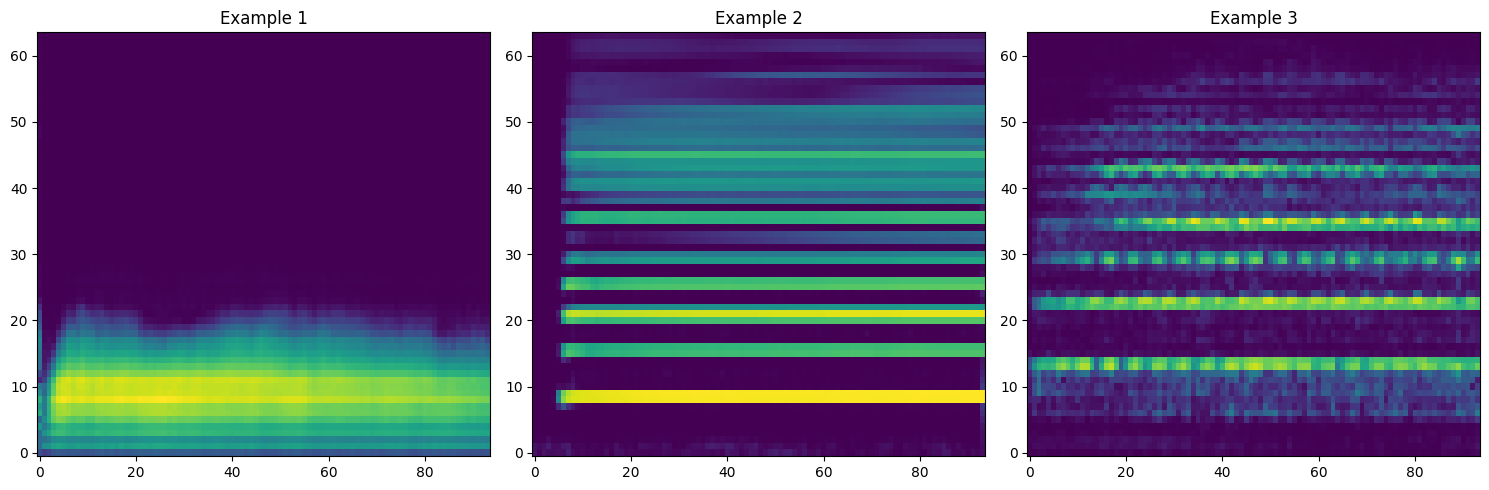

In [123]:
# Plot mel-spectrograms for debugging
import matplotlib.pyplot as plt

feature_extractor = FeatureExtractor(n_mels=64, n_fft=1024)

# Fetch a batch of data
batch = next(iter(train_loader))
mel_specs = feature_extractor(batch["audio"]).detach().numpy()
# Visualize the first three mel-spectrograms in the batch
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(mel_specs[i], aspect='auto', origin='lower')
    axes[i].set_title(f"Example {i+1}")
plt.tight_layout()
plt.show()

In [6]:
n_classes = len(set(val_dataset.natural_labels.values()))

batch = next(iter(val_loader))
mels = feature_extractor(batch["audio"])

print("Mel-spectrogram shape:", mels.shape)
print("Number of classes:", n_classes)

Mel-spectrogram shape: torch.Size([32, 64, 94])
Number of classes: 14


In [89]:
class MLP(nn.Module):
    def __init__(
        self,
        input_size,
        dense_size: int=64,
        n_classes: int=10,
    ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, dense_size)
        self.fc2 = nn.Linear(dense_size, dense_size)
        self.fc3 = nn.Linear(dense_size, n_classes)

    def forward(self, x):
        x = torch.flatten(x, 1, 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [119]:
class CNN(nn.Module):
    def __init__(
        self,
        kernel_size: int=3,
        poolin_size: int=4,
        dense_size: int=64,
        n_classes: int=10,
    ):
        super(CNN, self).__init__()
        self.dense_size = dense_size
        self.conv1 = nn.Conv2d(1, dense_size // 4, kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(dense_size // 4, dense_size// 2, kernel_size=kernel_size, stride=1, padding=1)
        self.conv3 = nn.Conv2d(dense_size // 2, dense_size, kernel_size=kernel_size, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=poolin_size, stride=poolin_size)
        self.fc1 = nn.Linear(dense_size, dense_size)
        self.fc2 = nn.Linear(dense_size, n_classes)  # Assuming 10 classes

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, self.dense_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Step 3: Train the models
Set up the training loop with loss functions and optimizers.


In [120]:
# Training loop
def train(model, n_epochs=3, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):

        # Training loop
        model.train()
        for i, batch in enumerate(train_loader):
            x, y = batch["audio"], batch["labels"]
            
            optimizer.zero_grad()

            # Extract features and forward step
            x = feature_extractor(x)
            y_est = model(x)

            loss = criterion(y_est, y)
            loss.backward()
            optimizer.step()

        loss_train = loss.item()

        # Validation loop
        model.eval()
        accs = []
        for i, batch in enumerate(val_loader):
            x, y = batch["audio"], batch["labels"]
            
            # Extract features and forward model
            x = feature_extractor(x)
            y_est = model(x)
            
            loss = criterion(y_est, y)

            y_est = y_est.softmax(dim=1)
            y_int = torch.argmax(y, dim=1).numpy()
            y_est_int = torch.argmax(y_est, dim=1).numpy()
            accs.append(accuracy_score(y_int, y_est_int))
        
        acc_val = np.mean(accs)
        loss_val = loss.item()

        print(
            f'Epoch [{epoch + 1}/{n_epochs}], ' +
            f'Train loss: {loss_train:.4f}, ' +
            f'Val loss: {loss_val:.4f}, ' +
            f'Val acc.: {acc_val:.4f}'
        )

In [124]:
mlp = MLP(mels.shape[1] * mels.shape[2], dense_size=32, n_classes=n_classes)
num_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print(f"MLP parameters: {num_params}")

cnn = CNN(dense_size=128, n_classes=n_classes)
num_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f"CNN Trainable parameters: {num_params}")


print("\nTraining MLP model")
train(mlp, n_epochs=10)

print("\nTraining CNN model")
train(cnn, n_epochs=10)

MLP parameters: 194062
CNN Trainable parameters: 110990

Training MLP model
Epoch [1/10], Train loss: 1.3420, Val loss: 0.5399, Val acc.: 0.5916
Epoch [2/10], Train loss: 1.0471, Val loss: 0.2850, Val acc.: 0.7105
Epoch [3/10], Train loss: 0.8775, Val loss: 0.2824, Val acc.: 0.6870
Epoch [4/10], Train loss: 0.8786, Val loss: 0.0475, Val acc.: 0.7615
Epoch [5/10], Train loss: 0.5179, Val loss: 0.3209, Val acc.: 0.7659
Epoch [6/10], Train loss: 0.5229, Val loss: 0.0485, Val acc.: 0.8076
Epoch [7/10], Train loss: 0.2715, Val loss: 0.0069, Val acc.: 0.8224
Epoch [8/10], Train loss: 0.6436, Val loss: 0.0203, Val acc.: 0.8240
Epoch [9/10], Train loss: 0.3806, Val loss: 0.3122, Val acc.: 0.8333
Epoch [10/10], Train loss: 0.3947, Val loss: 0.0168, Val acc.: 0.8141

Training CNN model
Epoch [1/10], Train loss: 1.2410, Val loss: 0.9708, Val acc.: 0.4567
Epoch [2/10], Train loss: 0.6339, Val loss: 0.3806, Val acc.: 0.6705
Epoch [3/10], Train loss: 0.4246, Val loss: 0.1053, Val acc.: 0.7780
Epoch 

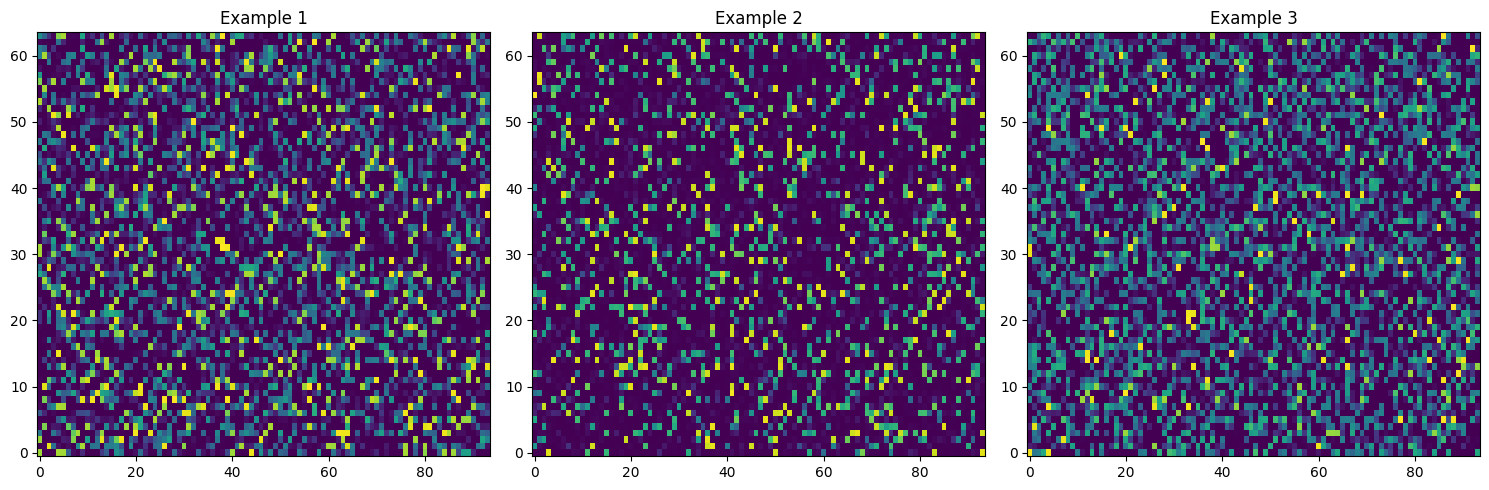

In [125]:
feature_extractor = FeatureExtractor(n_mels=64, n_fft=1024, randomize=True)

# Fetch a batch of data
batch = next(iter(train_loader))
mel_specs = feature_extractor(batch["audio"]).detach().numpy()

# Visualize the first three mel-spectrograms in the batch
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(mel_specs[i], aspect='auto', origin='lower')
    axes[i].set_title(f"Example {i+1}")
plt.tight_layout()
plt.show()

In [127]:
mlp = MLP(mels.shape[1] * mels.shape[2], dense_size=32, n_classes=n_classes)
num_params = sum(p.numel() for p in mlp.parameters() if p.requires_grad)
print(f"MLP parameters: {num_params}")

cnn = CNN(dense_size=128, n_classes=n_classes)
num_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f"CNN Trainable parameters: {num_params}")


print("\nTraining MLP model")
train(mlp, n_epochs=10)

print("\nTraining CNN model")
train(cnn, n_epochs=10)

MLP parameters: 194062
CNN Trainable parameters: 110990

Training MLP model
Epoch [1/10], Train loss: 2.5831, Val loss: 2.2267, Val acc.: 0.2160
Epoch [2/10], Train loss: 2.4284, Val loss: 1.9325, Val acc.: 0.2374
Epoch [3/10], Train loss: 2.5616, Val loss: 1.9563, Val acc.: 0.2374
Epoch [4/10], Train loss: 2.4669, Val loss: 2.0633, Val acc.: 0.2390
Epoch [5/10], Train loss: 2.4202, Val loss: 2.0763, Val acc.: 0.2374
Epoch [6/10], Train loss: 2.7033, Val loss: 2.0995, Val acc.: 0.2374
Epoch [7/10], Train loss: 2.5543, Val loss: 2.0541, Val acc.: 0.2374
Epoch [8/10], Train loss: 2.4334, Val loss: 1.9865, Val acc.: 0.2363
Epoch [9/10], Train loss: 2.2210, Val loss: 2.0833, Val acc.: 0.2489
Epoch [10/10], Train loss: 2.4065, Val loss: 1.9871, Val acc.: 0.2429

Training CNN model
Epoch [1/10], Train loss: 2.4629, Val loss: 1.8156, Val acc.: 0.2418
Epoch [2/10], Train loss: 2.5888, Val loss: 2.2075, Val acc.: 0.2374
Epoch [3/10], Train loss: 2.1102, Val loss: 1.9286, Val acc.: 0.2089
Epoch 